# Exploring Supernova Optical Depths: From Theory to Time Evolution

> **Note:** We strongly recommend turning off code autocompletion for this notebook. This exercise is designed to engage your understanding of how optical depths change over time in expanding supernova ejecta, building on the plasma physics concepts from the morning session.

In the morning session, you learned how to calculate the number densities that determine line absorption. Now we'll use a complete plasma solver to explore how **optical depths evolve over time** as a supernova expands and cools.

**$\blacktriangleright$ Key Question** - You've seen that optical depth depends on:
- Number density of absorbers in the lower level
- Line cross-section (oscillator strength × wavelength)
- Path length through the absorbing material

As a supernova expands, the ejecta density drops and the temperature changes. How do you think this affects the visibility of different spectral lines over time?

<div style="background-color: #e3f2fd; border-left: 4px solid #2196f3; padding: 10px; margin: 10px 0;">
<strong>**Focus:**</strong> This notebook emphasizes using plasma calculations to understand <strong>observational consequences</strong> rather than building the solver itself. You'll investigate when different lines dominate the spectrum and why Type Ia supernovae show characteristic spectral evolution.
</div>

## The Plasma Solver: Your Tool for Exploring Supernova Physics

We've provided you with a complete plasma solver that implements all the physics you learned in the morning session. This `Plasma` class handles:

- **Ionization balance** using the Saha equation
- **Excitation state populations** using Boltzmann statistics  
- **Optical depth calculations** using the Sobolev approximation

**$\blacktriangleright$ SN 2002bo-like Composition:**

The plasma solver uses fractional number densities based on SN 2002bo, a well-studied Type Ia supernova that serves as a template for typical ejecta composition:

In **MASS FRACTIONS** 

- **Oxygen (72.8%):** Dominant fusion product from explosive nucleosynthesis
- **Silicon (16.2%):** Key intermediate-mass element producing strong absorption lines  
- **Iron-peak elements (Fe: 2.3%, Ni: 2.8%):** Final products of complete silicon burning
- **Trace elements:** C, Mg, S, Ca, Ti, Cr provide additional spectroscopic diagnostics

This composition is reasonably accurate for the outer layers of SN2002bo ejecta. While real SN ejecta changes composition as you move through it, here we will look at a single composition, which we can think of as a "single cell" relevant for the outer layers. 

Your job is to use this tool to explore **how supernova spectra evolve over time** and understand the physical reasons behind the changes.



In [2]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from tardis.io.atom_data import AtomData, download_atom_data
from astropy import units as u, constants as const
import pandas as pd

Iterations:          0/? [00:00<?, ?it/s]

Packets:             0/? [00:00<?, ?it/s]

In [3]:
class Plasma():
    """
    A plasma class for calculating ionization and excitation states of elements.
    
    This plasma class uses fractional number densities based on an SN 2002bo-like 
    composition, which is representative of typical Type Ia supernova ejecta. 
    The composition emphasizes the products of explosive nucleosynthesis: primarily 
    oxygen (72.8%), silicon (16.2%), and iron-peak elements (Fe: 2.3%, Ni: 2.8%).
    
    Parameters
    ----------
    temp : astropy.units.Quantity
        Temperature of the plasma in units of temperature (e.g., Kelvin).
    atom_data : tardis.io.atom_data.base.AtomData
        Atomic data containing ionization energies, level data, and line data.
    elemental_scaling_dict : dict, optional
        Dictionary mapping element atomic numbers to scaling factors for 
        elemental abundances. Default is empty dict.
    
    Attributes
    ----------
    temp : astropy.units.Quantity
        Temperature of the plasma.
    atom_data : tardis.io.atom_data.base.AtomData
        Atomic data object.
    electron_density : astropy.units.Quantity
        Electron density of the plasma in units of cm^-3.
    elemental_scaling_dict : dict
        Scaling factors for elemental abundances.
    """
    
    def __init__(self, temp, atom_data, number_density, elemental_scaling_dict={}):
        electron_density_guess = 1e2 / u.cm**3
        self.temp = temp
        self.atom_data = atom_data
        self.electron_density = electron_density_guess
        self.elemental_scaling_dict = elemental_scaling_dict
        self.number_density = number_density * u.cm**-3
        
        # SN 2002bo-like fractional number densities
        # This composition represents typical Type Ia supernova ejecta with:
        # - Dominant O (72.8%): Primary product of explosive nucleosynthesis  
        # - Significant Si (16.2%): Important intermediate-mass element
        # - Iron-peak elements (Fe: 2.3%, Ni: 2.8%): Final fusion products
        # - Trace amounts of C, Mg, S, Ca, Ti, Cr for spectroscopic diagnostics
        self.base_atomic_numbers = {6: 5.007250580336478e-05,
        8: 0.7275914450748215,
        12: 0.00015915799637373565,
        14: 0.16177682953271233,
        16: 0.05661456428597796,
        20: 0.0032332688337799675,
        22: 5.3483346013897924e-06,
        24: 0.00018384504985324648,
        26: 0.022642706093005824,
        28: 0.027742762293070617}

        
    def solve_excitations(self, element, ionization_state):
        """
        Calculate the excitation populations for a given element and ionization state.
        
        Parameters
        ----------
        element : int
            Atomic number of the element.
        ionization_state : int
            Ionization state of the element (0 for neutral, 1 for singly ionized, etc.).
            
        Returns
        -------
        numpy.ndarray
            Array of fractional populations for each excitation level, normalized by
            the partition function.
        """
        degeneracies = self.atom_data.levels.loc[element, ionization_state].g.values
        energies = self.atom_data.levels.loc[element, ionization_state].energy.values
        frac_ionizations = degeneracies*np.exp(-energies * u.erg / const.k_B / self.temp)
        if element in self.elemental_scaling_dict:
            frac_ionizations *= self.elemental_scaling_dict[element] * self.base_atomic_numbers[element]
        elif element in self.base_atomic_numbers:
            frac_ionizations *= self.base_atomic_numbers[element]
        
        return frac_ionizations / self.partition_function(element, ionization_state) * self.number_density
    
    def partition_function(self, element, ionization_state):
        """
        Calculate the partition function for a given element and ionization state.
        
        Parameters
        ----------
        element : int
            Atomic number of the element.
        ionization_state : int
            Ionization state of the element (0 for neutral, 1 for singly ionized, etc.).
            
        Returns
        -------
        astropy.units.Quantity
            The partition function value (dimensionless).
        """
        degeneracies = self.atom_data.levels.loc[element, ionization_state].g.values
        energies = self.atom_data.levels.loc[element, ionization_state].energy.values
        beta = 1 / (const.k_B * self.temp)
        partition_function = np.sum(degeneracies * np.exp(-energies * u.erg * beta))
        
        return partition_function 
    
    def solve_ionization(self, element):
        """
        Calculate the ionization densities for all ionization states of an element.
        
        Uses the Saha equation to determine the relative populations of different
        ionization states in thermal equilibrium.
        
        Parameters
        ----------
        element : int
            Atomic number of the element.
            
        Returns
        -------
        numpy.ndarray
            Array of fractional ionization densities for each ionization state,
            normalized so that the sum equals 1.
        """
        ionization_data = self.atom_data.ionization_data.loc[element]
        beta = 1 / (const.k_B * self.temp)
        
        frac_ionization_densities = [1] * u.cm**-3
        last_partition_function = self.partition_function(element, 0)
        for ion_number in ionization_data.index.values:
            partition_function = self.partition_function(element, ion_number)
            frac_ionization_density = (2 * partition_function / last_partition_function * (2 * np.pi * const.m_e * const.k_B * self.temp / (const.h**2))**(3/2) * np.exp(-ionization_data.loc[ion_number] * u.erg * beta)) / self.electron_density

            frac_ionization_densities = np.append(frac_ionization_densities, frac_ionization_density * frac_ionization_densities[-1])
            last_partition_function = partition_function
        frac_ionization_densities = frac_ionization_densities / np.sum(frac_ionization_densities)
        if element in self.elemental_scaling_dict:
            frac_ionization_densities *= self.elemental_scaling_dict[element] * self.base_atomic_numbers[element]
        elif element in self.base_atomic_numbers:
            frac_ionization_densities *= self.base_atomic_numbers[element]
        return frac_ionization_densities * self.number_density
    
    def converge_ionization(self, show_electron_guess=False):
        """
        Iteratively solve for the electron density until convergence.
        
        This method iterates the ionization calculation until the electron density
        converges to a self-consistent value within the specified tolerance.
        
        Parameters
        ----------
        element_scaling_dict : dict, optional
            Dictionary mapping element atomic numbers to scaling factors for 
            elemental abundances. Default is empty dict.
            
        Returns
        -------
        None
            Updates the electron_density attribute in place.
            
        Notes
        -----
        The method prints iteration information during convergence.
        Convergence is determined when the relative change in electron density
        is less than 1e-5.
        """
        converged = False
        tolerance = 1e-5 
        last_electron_guess = 1e99 * u.cm**-3
        iterations = 0 
        
        while not converged:
            if show_electron_guess:
                print(f'Iteration {iterations}, last electron density: {self.electron_density:.2g}')
            iterations += 1
            last_electron_guess = self.electron_density
            new_electron_density = 0 * u.cm**-3
            for element in self.atom_data.ionization_data.index.get_level_values(0).unique().values:
                if element in self.elemental_scaling_dict:
                    scaling_factor = self.elemental_scaling_dict[element] * self.base_atomic_numbers[element]
                elif element in self.base_atomic_numbers:
                    scaling_factor = self.base_atomic_numbers[element]
                else:
                    scaling_factor = 1.0
                elemental_ionization_array = self.solve_ionization(element)
                ions_per_element = np.arange(len(elemental_ionization_array)) * scaling_factor
                electrons_array = elemental_ionization_array * ions_per_element
                elemental_electron_density = np.sum(electrons_array) 
                new_electron_density += elemental_electron_density
            self.electron_density = new_electron_density
            if np.abs((self.electron_density - last_electron_guess)/last_electron_guess) < tolerance:
                converged = True
                print(f'Converged after {iterations} iterations with electron density: {self.electron_density}. Setting the electron density to this number for your plasma.')
                
                
    def calculate_tau_sobolev(self, element, ionization_state, lower, upper, time_since_explosion):
        """
        Calculate the Sobolev optical depth for a specific transition.
        
        Parameters
        ----------
        element : int
            Atomic number of the element.
        ionization_state : int
            Ionization state of the element (0 for neutral, 1 for singly ionized, etc.).
        lower : int
            Lower energy level index for the transition.
        upper : int
            Upper energy level index for the transition.
        time_since_explosion : astropy.units.Quantity
            Time since explosion in units of time (e.g., seconds).
            
        Returns
        -------
        astropy.units.Quantity
            The Sobolev optical depth (dimensionless).
            
        Notes
        -----
        The Sobolev optical depth is calculated using the line cross-section,
        population density of the lower level, and the expansion time.
        """
        line_data = self.atom_data.lines.loc[(element, ionization_state, lower, upper)]
        f_lu = line_data.f_lu
        wavelength = line_data.wavelength
        
        sigma_line = np.pi * const.e.gauss**2 / (const.m_e * const.c) * f_lu.values 
        n_ion = self.solve_ionization(element)[ionization_state]
        n_excitation_state = self.solve_excitations(element, ionization_state)[lower] 
        
        n_lower = n_ion * n_excitation_state
        
        
        tau = n_lower * sigma_line * time_since_explosion * wavelength.values * u.AA / self.number_density

        return tau.to(1).value[0]

## Understanding Python Classes (If You're New to Them)
### If you're not you can skip this. 

If you're not familiar with Python classes, think of them as **containers that hold both data and functions together**. A class is like a blueprint for creating objects that can:

- **Store data** (variables, parameters, results)
- **Perform actions** (functions that operate on that data)

For example, our `Plasma` class stores:
- **Data:** temperature, density, electron density, atomic data
- **Functions:** methods to calculate ionization states, optical depths, etc.

When we create a plasma object like `plasma = Plasma(10000*u.K, ...)`, we're making a specific instance with particular values that remembers its state and can perform calculations. This keeps all the plasma physics organized in one place rather than having separate variables and functions scattered throughout the code.

**Bottom line:** Classes help organize complex calculations by bundling related data and functions together - perfect for plasma physics where many quantities depend on each other!

## Understanding the Plasma Class

The `Plasma` class below encapsulates all the physics you learned this morning in a computational tool. You don't need to understand every line of code, but notice the key methods:

- `solve_ionization()` - implements the Saha equation for ionization balance
- `solve_excitations()` - uses Boltzmann statistics for level populations  
- `calculate_tau_sobolev()` - computes optical depths for specific transitions
- `converge_ionization()` - self-consistently solves for electron density

**$\blacktriangleright$ For now, Focus on Physics, Not Code** - Your goal is to use this tool to explore how physical conditions affect observable quantities, not to debug the implementation.

In [4]:
download_atom_data('kurucz_cd23_chianti_H_He_latest')
adata = AtomData.from_hdf('kurucz_cd23_chianti_H_He_latest.h5')

Atomic Data kurucz_cd23_chianti_H_He_latest already exists in /Users/joshuashields/Downloads/tardis-data/kurucz_cd23_chianti_H_He_latest.h5. Will not download - override with force_download=True.


## Exploring the Atomic Data

Before diving into plasma calculations, let's explore the atomic database to understand what spectral lines are available for our analysis.

**$\blacktriangleright$ Atomic Data Structure:** The atomic data contains information about:
- **Elements and ions:** Ionization states for each element
- **Energy levels:** Excitation states within each ion
- **Transitions:** Line data connecting different energy levels
- **Line parameters:** Wavelengths, oscillator strengths, transition probabilities

Let's look at use one of the two transitions in the $\lambda\lambda$ 6355 $\AA$ Si II transition.

14, 1, 7, 15 means we want the 14th element (Silicon) in the 1st excited state (II) transitioning from excitation level 7 to 15. 

In [5]:
adata.lines.loc[(14, 1, 7, 15)]

/var/folders/n4/hw688njd0_1164p8dnqc6v_h0000gn/T/ipykernel_65140/225784927.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  adata.lines.loc[(14, 1, 7, 15)]


,,,,line_id,wavelength,f_ul,f_lu,nu,B_lu,B_ul,A_ul,wavelength_cm
atomic_number,ion_number,level_number_lower,level_number_upper,,,,,,,,,
14,1,7,15,65494,6348.864031,0.495382,0.990764,4.721986e+14,1.056092e+11,5.280458e+10,8.197665e+07,0.000063


# Using the Plasma Solver

Now let's test our plasma solver with conditions typical of Type Ia supernova ejecta. We'll start with a simple case to see how it works, then explore how optical depths change over time.

**$\blacktriangleright$ Initial Conditions** - We'll start with:
- **Temperature:** 10,000 K (typical of SN Ia photospheres)
- **Number density:** 10^8 cm^-3 (characteristic of expanding ejecta)
- **Scaled Composition** 10 times as much Mg as base, just to show how to use the scaler

This represents conditions you might find in the outer ejecta of a Type Ia supernova a few weeks after explosion.

In [6]:
plasma = Plasma(10000*u.K, atom_data=adata, elemental_scaling_dict={12: 10}, number_density=1e8)

In [7]:
plasma.converge_ionization(show_electron_guess=True)

Iteration 0, last electron density: 1e+02 1 / cm3
Iteration 1, last electron density: 4.5e+09 1 / cm3
Iteration 2, last electron density: 3e+09 1 / cm3
Iteration 3, last electron density: 3e+09 1 / cm3
Iteration 4, last electron density: 3e+09 1 / cm3
Converged after 5 iterations with electron density: 3006257425.712275 1 / cm3. Setting the electron density to this number for your plasma.


The calculate_tau_sobolev method wants you to specify a line transition and a time to evaluate the plasma at. We'll examine the same line that we looked at in the atomic data. 

14, 1, 7, 15 means we want the 14th element (Silicon) in the 1st excited state (II) transitioning from excitation level 7 to 15. 
We then get out an optical depth for the line at that time, which incorporates some assumptions about the ejecta and how it evolves with time, wrapped in to the Sobolev approximation. 

In [8]:
plasma.calculate_tau_sobolev(14, 1, 7, 15, 14*u.d)

/var/folders/n4/hw688njd0_1164p8dnqc6v_h0000gn/T/ipykernel_65140/2794084687.py:224: PerformanceWarning: indexing past lexsort depth may impact performance.
  line_data = self.atom_data.lines.loc[(element, ionization_state, lower, upper)]


np.float64(0.09143890148946228)

**$\blacktriangleright$ TASK: Parameter Exploration**

Try modifying some of the plasma parameters to see how they affect the optical depth calculation:

1. **Elemental Composition Effects:**
    - Try `elemental_scaling_dict={14: 5}` to enhance silicon abundance
    - Try `elemental_scaling_dict={26: 0.1}` to reduce iron content

2. **Temperature Sensitivity:**
    - Cool plasma: `Plasma(8000*u.K, ...)` 
    - Hot plasma: `Plasma(15000*u.K, ...)`
    - How does this affect ionization balance?

3. **Density Variations:**
    - High density: `number_density=1e9`
    - Low density: `number_density=1e7` 
    - What happens to electron density and line strengths?

4. **Different Transitions:**
    - Try the other Si II line: `(14, 1, 7, 13)`
    - Test a Ca II line: `(20, 1, 2, 4)`
    - Explore different elements available in the atomic data

**$\blacktriangleright$ Physics Questions to Consider:**

- Which parameter changes have the biggest impact on optical depths?
- How do temperature and density changes affect the ionization balance differently?
- Can you find conditions where weak lines become dominant?
- What happens if you enhance the abundance of trace elements?

**Challenge:** Try to find plasma conditions that maximize the optical depth for a specific transition of your choice!

# Solution

2. Higher temperatures are generally more ionized, which we can recall from the ionization equation. 

3. Higher number densities lead to more of everything, but also to less more highly ionized elements. This can be understood in the equation we saw in the morning where you divide by electron density for ionized elements, or can be thought about as more free electrons means elements can recombine faster. 

In [9]:
plasma = Plasma(10000*u.K, atom_data=adata, number_density=1e8, elemental_scaling_dict={12: 5})
plasma.converge_ionization(show_electron_guess=True)

plasma.solve_ionization(26)

Iteration 0, last electron density: 1e+02 1 / cm3
Iteration 1, last electron density: 4.5e+09 1 / cm3
Iteration 2, last electron density: 3e+09 1 / cm3
Iteration 3, last electron density: 3e+09 1 / cm3
Iteration 4, last electron density: 3e+09 1 / cm3
Converged after 5 iterations with electron density: 3006257056.1445675 1 / cm3. Setting the electron density to this number for your plasma.


<Quantity [2.60217341e-006, 4.87883120e+002, 2.26348026e+006,
           3.02468400e+002, 3.83652641e-013, 1.04682668e-038,
           1.54391402e-076, 1.16465045e-127, 1.60800399e-192,
           1.92731430e-297, 0.00000000e+000, 0.00000000e+000,
           0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
           0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
           0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
           0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
           0.00000000e+000, 0.00000000e+000, 0.00000000e+000] 1 / cm3>

## Spectroscopic Analysis Tool: Wavelength vs. Optical Depth

Below we provide a plotting function that will create a plasma with the specified parameters and then plot the optical depths of certain lines versus their wavelengths.

<div style="background-color: #fff3cd; border-left: 4px solid #ffb74d; padding: 10px; margin: 10px 0;">
<strong>**Optional Customization:**</strong> If you want to add your own lines to track, you can change the analysis lines section within the function. Just note that the atomic data does not have lines for every single possible transition, so if you include a line that is not present then the code may crash.
</div>

In [10]:
def plot_wavelength_vs_tau(time=15*u.d, atom_data=adata, density=5e7, temperature=10000*u.K, elemental_scale={}):
    """
    Plot wavelength vs optical depth for famous Type Ia supernova lines.
    
    Parameters
    ----------
    time : astropy.units.Quantity
        Time since explosion (default: 15 days)
    density : float
        Number density in cm^-3 (default: 5e7)
    temperature : astropy.units.Quantity
        Plasma temperature (default: 10000 K)
    elemental_scale : dict
        Elemental scaling factors for specific elements (default: empty dict)
    """
    
    # Create plasma with requested conditions
    custom_plasma = Plasma(temperature, atom_data=atom_data, number_density=density, elemental_scaling_dict=elemental_scale)
    custom_plasma.converge_ionization()

    # Define lines to analyze
    analysis_lines = {
        'Si II 6371': (14, 1, 7, 15),
        'Si II 6347': (14, 1, 7, 13),
        'Si II 5980': (14, 1, 15, 20),
        'Si II 5900': (14, 1, 13, 20),        
        'Ca II 8544': (20, 1, 2, 4),
        'Ca II 8538': (20, 1, 1, 3),
        'C II 6580': (12, 1, 14, 38),
        'C II 6580 2': (12, 1, 15, 37),
    }

    # Calculate wavelengths and optical depths
    wavelengths = []
    tau_values = []
    line_labels = []

    for line_name, (element, ion, lower, upper) in analysis_lines.items():
        line_data = adata.lines.loc[(element, ion, lower, upper)]
        wavelength = line_data.wavelength.values[0]
        tau = custom_plasma.calculate_tau_sobolev(element, ion, lower, upper, time)
        
        wavelengths.append(wavelength)
        tau_values.append(tau)
        line_labels.append(line_name)

    # Convert to numpy arrays
    wavelengths = np.array(wavelengths)
    tau_values = np.array(tau_values)

    # Create the plot
    plt.figure(figsize=(14, 8))
    colors = plt.cm.viridis(np.linspace(0, 1, len(wavelengths)))

    for i, (wl, tau, label, color) in enumerate(zip(wavelengths, tau_values, line_labels, colors)):
        plt.scatter(wl, tau, s=120, alpha=0.8, color=color, edgecolors='black', linewidth=1)
        plt.annotate(label, (wl, tau), xytext=(8, 8), textcoords='offset points', 
                    fontsize=11, fontweight='bold', alpha=0.9,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

    plt.xlabel('Wavelength (Å)', fontsize=14)
    plt.ylabel('Sobolev Optical Depth', fontsize=14)
    plt.title('Optical Depth vs Wavelength\n' + 
              f'Time: {time.value:.0f} days, ' +
              f'Temperature: {temperature.value:.0f} K, ' +
              f'Density: {density:.1e} cm⁻³', fontsize=16)

    plt.yscale('log')
    plt.grid(True, alpha=0.3)

    # Add reference lines
    plt.axhline(y=1, color='red', linestyle='--', alpha=0.8, linewidth=2, 
               label='τ = 1 (optically thick threshold)')
    plt.axhline(y=0.1, color='orange', linestyle=':', alpha=0.7, linewidth=2,
               label='τ = 0.1 (weak absorption)')

    plt.legend(fontsize=12)
    plt.tight_layout()
    # plt.show()

    # Print summary information
    print("\nPlasma Conditions:")
    print(f"Time: {time}")
    print(f"Temperature: {temperature}")
    print(f"Number Density: {density:.1e} cm⁻³")
    print(f"Electron Density: {custom_plasma.electron_density:.2e}")
    print(f"\nWavelength range: {wavelengths.min():.0f} - {wavelengths.max():.0f} Å")
    print(f"Optical depth range: {np.min(tau_values):.2e} - {np.max(tau_values):.2e}")
    print("\nLines with τ > 1 (optically thick):")
    for wl, tau, label in zip(wavelengths, tau_values, line_labels):
        if tau > 1:
            print(f"  {label}: λ = {wl:.0f} Å, τ = {tau:.2e}")


## **INVESTIGATION 1:** Spectroscopic Snapshot Analysis

Your first tool is a function that creates **spectroscopic snapshots**—showing you which lines dominate the spectrum at any given time and physical conditions. This is analogous to taking an actual spectrum of a supernova.

**$\blacktriangleright$ Research Strategy:**

You'll systematically vary conditions to understand what controls spectral appearance:

1. **Time dependence:** How do line strengths change as the supernova evolves?
2. **Temperature sensitivity:** How does cooling affect ionization and excitation? 

**$\blacktriangleright$ Key Diagnostic Questions:**

As you explore different conditions, ask yourself:
- Which lines have τ > 1 (optically thick, observable) vs. τ < 1 (optically thin, weak)?
- Can you identify why certain lines are used for supernova classification?


The function `plot_wavelength_vs_tau()` is your primary diagnostic tool for this section. Let's see how it works.

Converged after 5 iterations with electron density: 14481142099.861895 1 / cm3. Setting the electron density to this number for your plasma.


/var/folders/n4/hw688njd0_1164p8dnqc6v_h0000gn/T/ipykernel_65140/4041520464.py:39: PerformanceWarning: indexing past lexsort depth may impact performance.
  line_data = adata.lines.loc[(element, ion, lower, upper)]
/var/folders/n4/hw688njd0_1164p8dnqc6v_h0000gn/T/ipykernel_65140/2794084687.py:224: PerformanceWarning: indexing past lexsort depth may impact performance.
  line_data = self.atom_data.lines.loc[(element, ionization_state, lower, upper)]



Plasma Conditions:
Time: 6.0 d
Temperature: 10000.0 K
Number Density: 5.0e+08 cm⁻³
Electron Density: 1.45e+10 1 / cm3

Wavelength range: 5959 - 8665 Å
Optical depth range: 6.88e-11 - 9.42e-01

Lines with τ > 1 (optically thick):


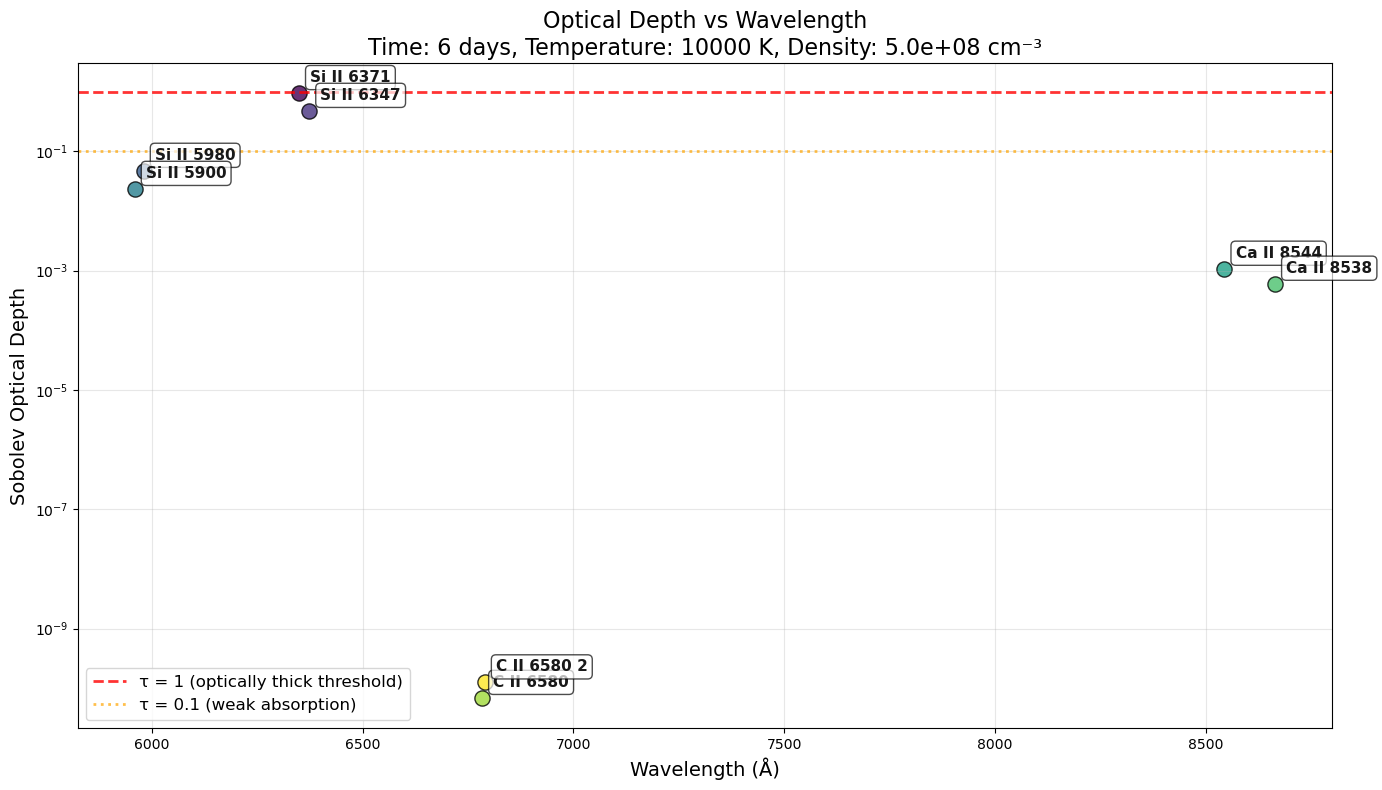

In [11]:
plot_wavelength_vs_tau(time=6*u.d, density=5e8, temperature=10000*u.K, elemental_scale={8: 1, 12:1})
plt.show()

We can load in a 6 day SN2002bo spectrum for comparison. 

Our plasma solver here is quite rudimentary, but we can still recover many of the strongest supernova lines with this description.

In [12]:
sn2002bo_spec = pd.read_csv('SN2002bo_2002-03-11_06-14-24_Lick-3m_KAST_BSNIP.dat', sep=r'\s+', names=['wavelength', 'flux'])

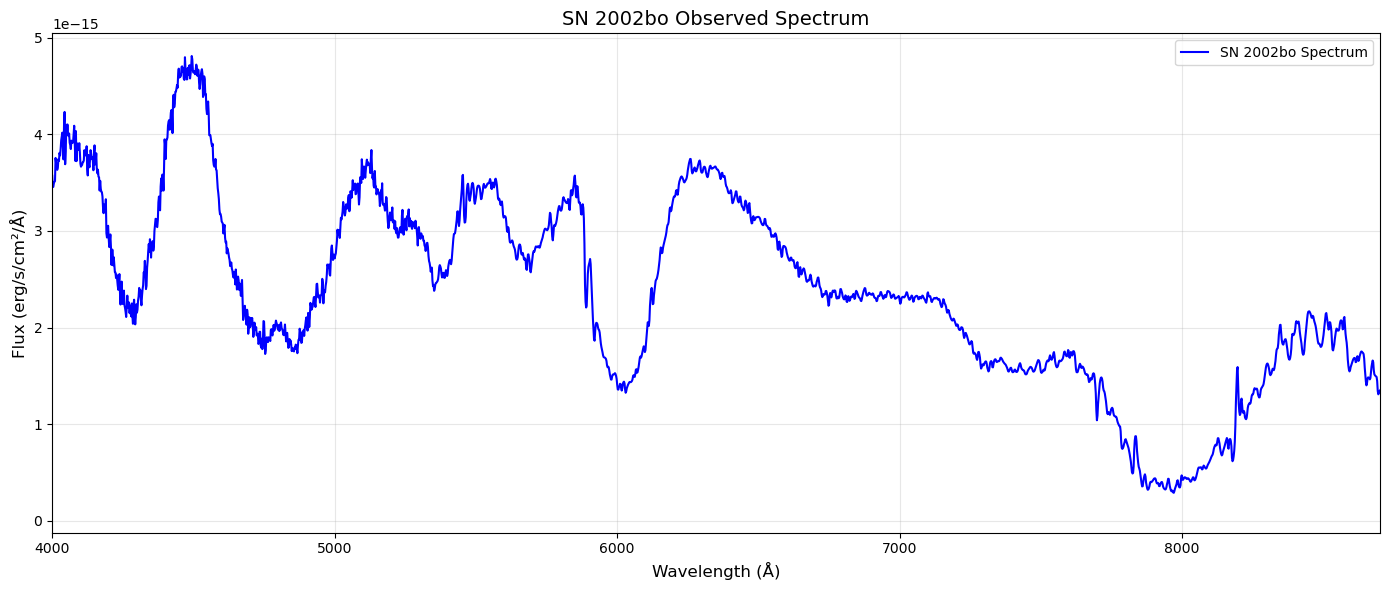

In [13]:
plt.figure(figsize=(14, 6))
plt.plot(sn2002bo_spec['wavelength'], sn2002bo_spec['flux'], label='SN 2002bo Spectrum', color='blue')
plt.xlim(4000, 8700)
plt.xlabel('Wavelength (Å)', fontsize=12)
plt.ylabel('Flux (erg/s/cm²/Å)', fontsize=12)
plt.title('SN 2002bo Observed Spectrum', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Let's overplot the two so we can line up the spectrum with our optical depth calculations. 

Converged after 6 iterations with electron density: 138582472611.81598 1 / cm3. Setting the electron density to this number for your plasma.

Plasma Conditions:
Time: 6.0 d
Temperature: 10000.0 K
Number Density: 5.0e+09 cm⁻³
Electron Density: 1.39e+11 1 / cm3

Wavelength range: 5959 - 8665 Å
Optical depth range: 6.57e-09 - 8.78e+01

Lines with τ > 1 (optically thick):
  Si II 6371: λ = 6349 Å, τ = 8.78e+01
  Si II 6347: λ = 6373 Å, τ = 4.42e+01
  Si II 5980: λ = 5981 Å, τ = 4.37e+00
  Si II 5900: λ = 5959 Å, τ = 2.18e+00


/var/folders/n4/hw688njd0_1164p8dnqc6v_h0000gn/T/ipykernel_65140/4041520464.py:39: PerformanceWarning: indexing past lexsort depth may impact performance.
  line_data = adata.lines.loc[(element, ion, lower, upper)]
/var/folders/n4/hw688njd0_1164p8dnqc6v_h0000gn/T/ipykernel_65140/2794084687.py:224: PerformanceWarning: indexing past lexsort depth may impact performance.
  line_data = self.atom_data.lines.loc[(element, ionization_state, lower, upper)]


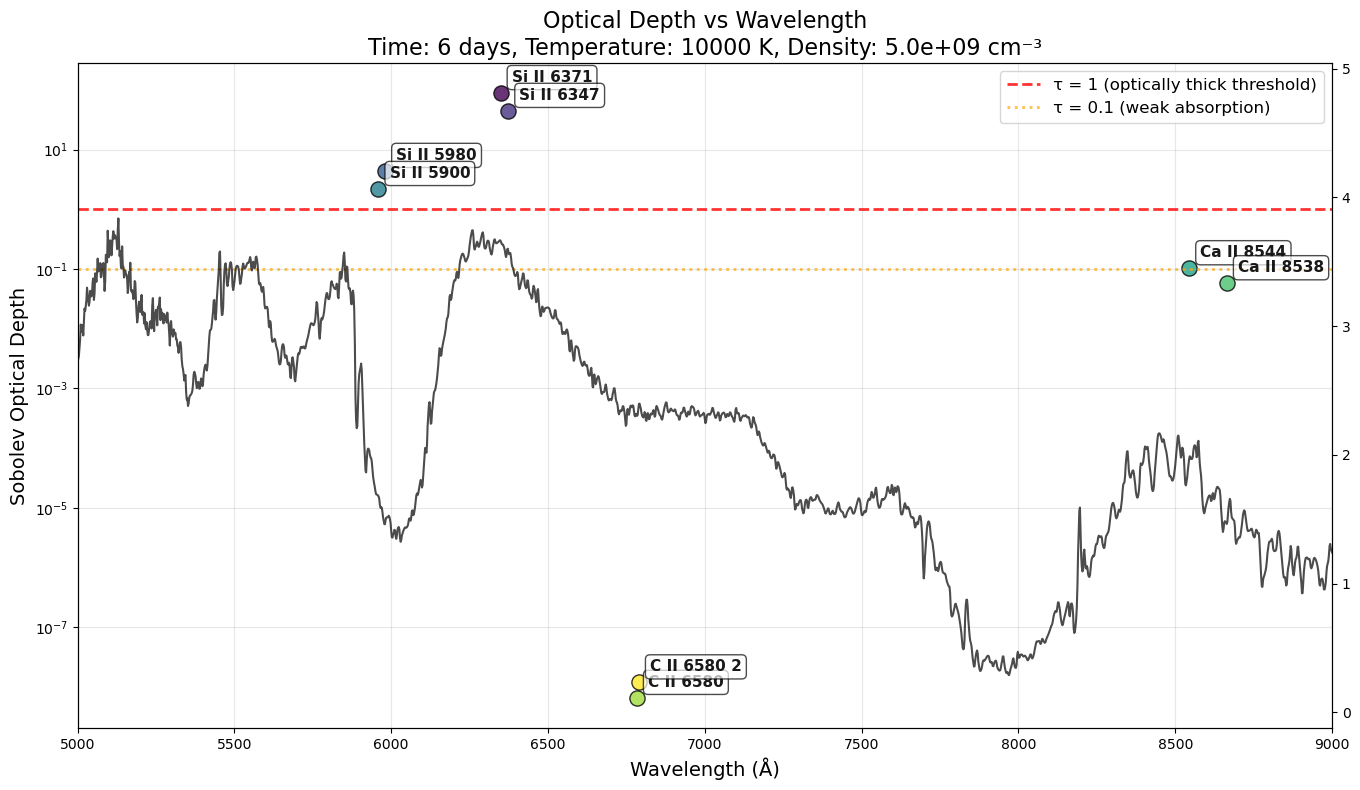

In [14]:
# Create the optical depth plot
plot_wavelength_vs_tau(time=6*u.d, density=5e9, temperature=10000*u.K)

# Add the observed spectrum to the same figure
ax_twin = plt.gca().twinx()
ax_twin.plot(sn2002bo_spec['wavelength'], sn2002bo_spec['flux'] * 1e15, label='SN 2002bo Spectrum (scaled)', color='black', alpha=0.7)

plt.xlim(5000, 9000)
plt.show()


### **ANALYZE YOUR FIRST RESULT**

Examine the plot you just generated carefully. This represents a supernova spectrum snapshot at early times (6 day) with high density conditions, overlaid with the actual observed SN 2002bo spectrum.

**$\blacktriangleright$ Diagnostic Questions:**

1. **Line Hierarchy:** Which lines have the highest optical depths? How do these correspond to the strongest absorption features in the observed spectrum?

2. **Physical Interpretation:** The τ = 1 line marks the transition between optically thick and thin regimes. Which lines are observable (τ > 1) vs. weak (τ < 1)? Do the optically thick lines match the prominent absorptions in the spectrum?

3. **Classification Insight:** Based on this result, can you see why astronomers use Si II lines to identify Type Ia supernovae?

4. **Wavelength Shifts:** Notice that our calculated rest wavelengths are generally at somewhat longer wavelengths than the corresponding absorption features in the observed spectrum. What physical effect causes this systematic shift toward shorter wavelengths in the observed spectrum? (Hint: Think about the expanding ejecta and Doppler effects.)

**$\blacktriangleright$ TASK: Systematic Exploration**

Now experiment by changing the parameters in the function call above:
- **Time effects:** Try `time=30*u.d` — how do line strengths change? Be careful to note that changing the time of simulation but not the density is not the same ejecta. 
- **Density effects:** Try `density=1e7` — what happens to overall optical depths?
- **Temperature effects:** Try `temperature=15000*u.K` — how does this affect ionization?

**What patterns do you observe? What physical principles explain these changes?**

Try to run the simulation a couple more times, but changing the number densities of specific elements. How do the line optical depths respond?

# Solution cell

1. The strongest features generally have high optical depths.

2. Again, the lines with high optical depths make large imprints on the spectrum, but it's not guaranteed that that those lines have optical depth greater than 1 either.

3. Si II 6355 is one of the highest optical depth transitions in the optical regime for the most SN Ia like plasmas. 

4. To make sense of these wavelength shifts, we recall our p-cyngi profiles, where the absorption is mostly dominated by blueshifted ejecta, from the front of the ejecta. The emission comes from the sides of the supernova where phottons are scattered into the line of sight and the ejecta expands perpendicular to the line of sight. We'll see this more tomorrow too. 

Converged after 5 iterations with electron density: 14481142099.861895 1 / cm3. Setting the electron density to this number for your plasma.

Plasma Conditions:
Time: 1.0 d
Temperature: 10000.0 K
Number Density: 5.0e+08 cm⁻³
Electron Density: 1.45e+10 1 / cm3

Wavelength range: 5959 - 8665 Å
Optical depth range: 1.15e-11 - 1.57e-01

Lines with τ > 1 (optically thick):


/var/folders/n4/hw688njd0_1164p8dnqc6v_h0000gn/T/ipykernel_65140/4041520464.py:39: PerformanceWarning: indexing past lexsort depth may impact performance.
  line_data = adata.lines.loc[(element, ion, lower, upper)]
/var/folders/n4/hw688njd0_1164p8dnqc6v_h0000gn/T/ipykernel_65140/2794084687.py:224: PerformanceWarning: indexing past lexsort depth may impact performance.
  line_data = self.atom_data.lines.loc[(element, ionization_state, lower, upper)]


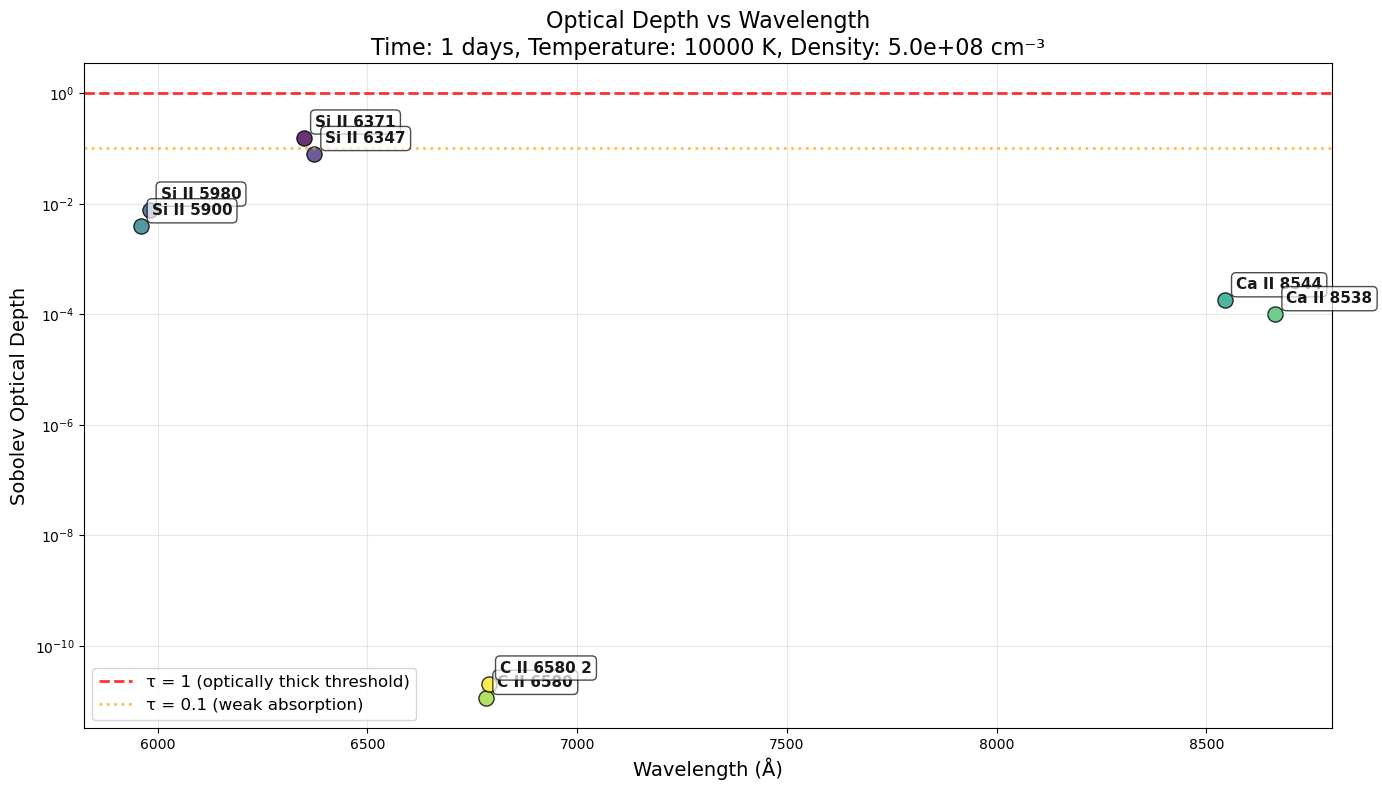

In [15]:
plot_wavelength_vs_tau(time=1*u.d, density=5e8, temperature=10000*u.K, elemental_scale={8:1, 14:1}) # Change the elemental scale

**$\blacktriangleright$ TASK: Systematic Comparison with Observations**

Now experiment with different plasma conditions to see how well you can match the observed spectrum patterns. Try to understand which conditions produce optical depth patterns most consistent with the observed absorption features.

**Challenge Questions:**
1. **Temperature Effects:** How does changing the plasma temperature affect which lines dominate? Try both hotter and cooler conditions.
2. **Density Sensitivity:** What happens when you increase or decrease the total density? How does this affect the overall strength of absorption features?
3. **Composition Variations:** What if certain elements were more or less abundant? How would this change the relative line strengths?

Converged after 6 iterations with electron density: 104747348435.38875 1 / cm3. Setting the electron density to this number for your plasma.

Plasma Conditions:
Time: 6.0 d
Temperature: 8000.0 K
Number Density: 5.0e+09 cm⁻³
Electron Density: 1.05e+11 1 / cm3

Wavelength range: 5959 - 8665 Å
Optical depth range: 1.39e-08 - 2.32e+02

Lines with τ > 1 (optically thick):
  Si II 6371: λ = 6349 Å, τ = 2.32e+02
  Si II 6347: λ = 6373 Å, τ = 1.17e+02
  Si II 5980: λ = 5981 Å, τ = 6.56e+00
  Si II 5900: λ = 5959 Å, τ = 3.27e+00
  Ca II 8544: λ = 8544 Å, τ = 2.06e+00
  Ca II 8538: λ = 8665 Å, τ = 1.16e+00


/var/folders/n4/hw688njd0_1164p8dnqc6v_h0000gn/T/ipykernel_65140/4041520464.py:39: PerformanceWarning: indexing past lexsort depth may impact performance.
  line_data = adata.lines.loc[(element, ion, lower, upper)]
/var/folders/n4/hw688njd0_1164p8dnqc6v_h0000gn/T/ipykernel_65140/2794084687.py:224: PerformanceWarning: indexing past lexsort depth may impact performance.
  line_data = self.atom_data.lines.loc[(element, ionization_state, lower, upper)]


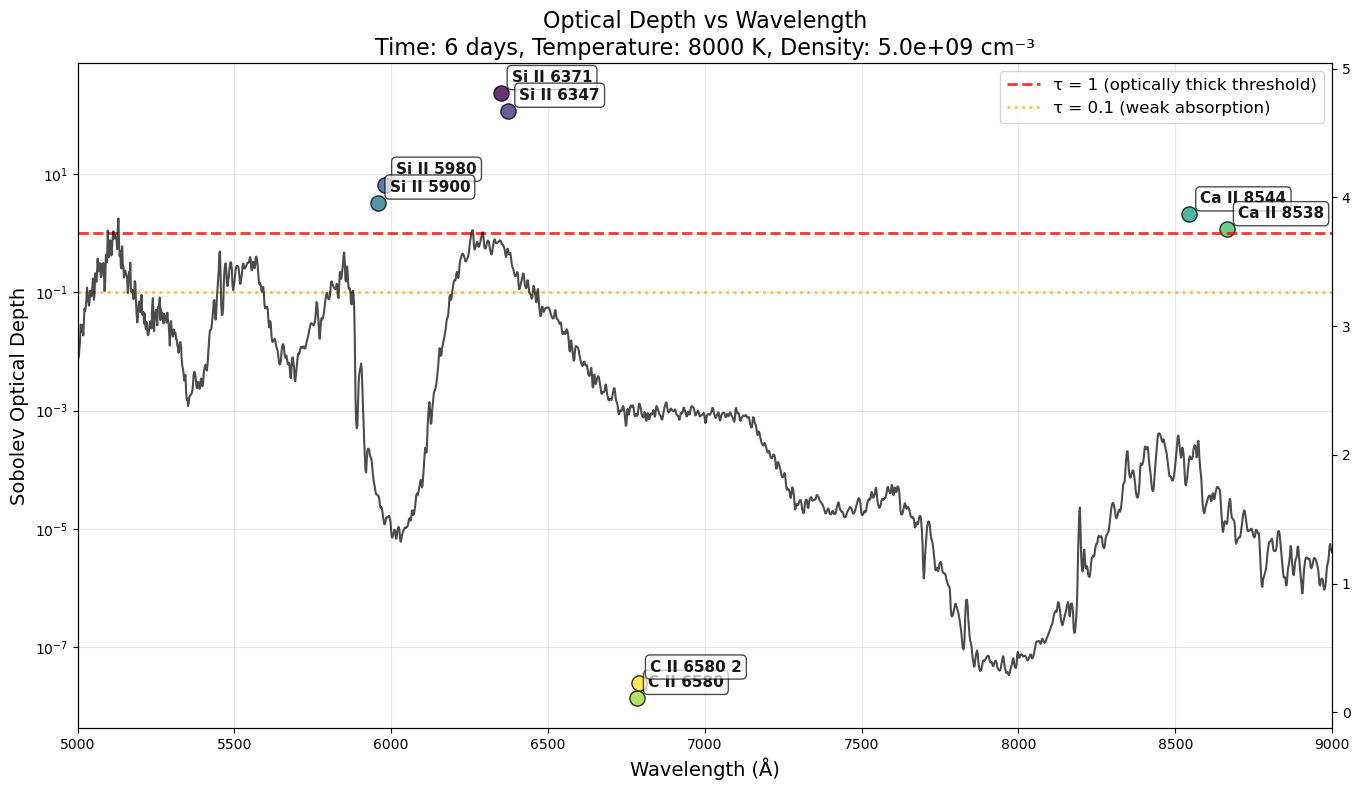

In [16]:
# Try different temperatures - how does this affect the match with observations?
plot_wavelength_vs_tau(time=6*u.d, density=5e9, temperature=8000*u.K)

# Add the observed spectrum for comparison
ax_twin = plt.gca().twinx()
ax_twin.plot(sn2002bo_spec['wavelength'], sn2002bo_spec['flux'] * 1e15, label='SN 2002bo Spectrum (scaled)', color='black', alpha=0.7)
plt.xlim(5000, 9000)
plt.show()

Converged after 6 iterations with electron density: 139335039025.51935 1 / cm3. Setting the electron density to this number for your plasma.

Plasma Conditions:
Time: 6.0 d
Temperature: 10000.0 K
Number Density: 5.0e+09 cm⁻³
Electron Density: 1.39e+11 1 / cm3

Wavelength range: 5959 - 8665 Å
Optical depth range: 6.60e-09 - 3.53e+02

Lines with τ > 1 (optically thick):
  Si II 6371: λ = 6349 Å, τ = 3.53e+02
  Si II 6347: λ = 6373 Å, τ = 1.78e+02
  Si II 5980: λ = 5981 Å, τ = 1.76e+01
  Si II 5900: λ = 5959 Å, τ = 8.75e+00


/var/folders/n4/hw688njd0_1164p8dnqc6v_h0000gn/T/ipykernel_65140/4041520464.py:39: PerformanceWarning: indexing past lexsort depth may impact performance.
  line_data = adata.lines.loc[(element, ion, lower, upper)]
/var/folders/n4/hw688njd0_1164p8dnqc6v_h0000gn/T/ipykernel_65140/2794084687.py:224: PerformanceWarning: indexing past lexsort depth may impact performance.
  line_data = self.atom_data.lines.loc[(element, ionization_state, lower, upper)]


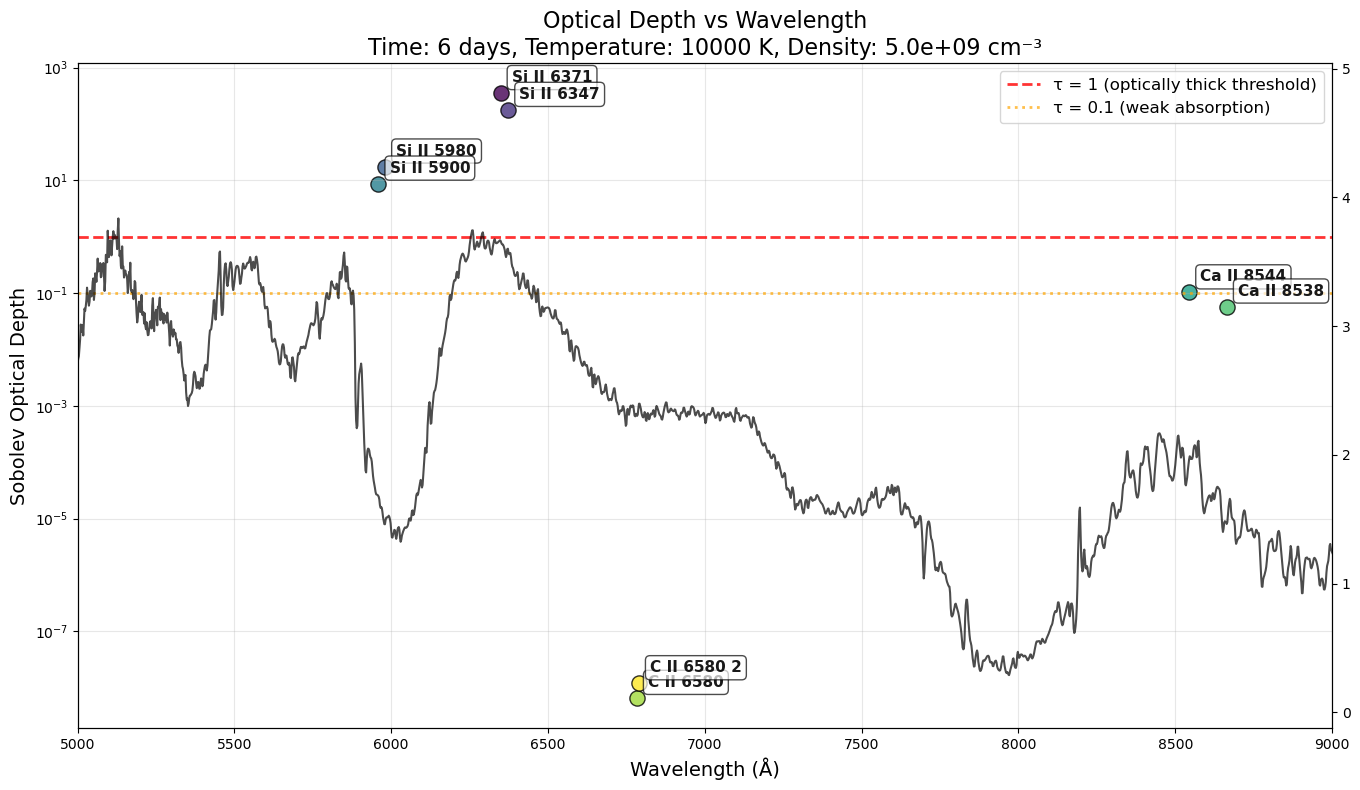

In [17]:
# Try enhancing silicon abundance - does this improve the Si II line match?
plot_wavelength_vs_tau(time=6*u.d, density=5e9, temperature=10000*u.K, elemental_scale={14: 2})

# Add the observed spectrum for comparison
ax_twin = plt.gca().twinx()
ax_twin.plot(sn2002bo_spec['wavelength'], sn2002bo_spec['flux'] * 1e15, label='SN 2002bo Spectrum (scaled)', color='black', alpha=0.7)
plt.xlim(5000, 9000)
plt.show()

**$\blacktriangleright$ TASK: Interpretation Questions**

After trying different plasma conditions, reflect on your results:

1. **Best Match Conditions:** Which combination of temperature, density, and composition gave you the best agreement between optical depth patterns and observed absorption features?

2. **Physical Realism:** Do your "best fit" conditions seem physically reasonable for a Type Ia supernova 6 days after explosion?

3. **Doppler Shift Understanding:** You should notice that the rest wavelengths of your calculated lines are systematically longer than the absorption minima in the observed spectrum. This is because the observed spectrum shows **blueshifted absorption** due to the expanding ejecta moving toward us. The absorption occurs in material with velocities of ~10,000-15,000 km/s, causing significant Doppler shifts: Δλ/λ ≈ v/c.

4. **Model Limitations:** What aspects of real supernova physics are missing from our simple plasma model that might explain remaining discrepancies?

**Key Insight:** This exercise demonstrates how theoretical plasma physics connects to real observations, but also reveals the complexity of fully modeling supernova spectra!

In [18]:
def calculate_optical_depth_evolution(reference_density_10d=1e8, plasma_temperature=10000*u.K, 
                                    time_range=(1, 30), num_points=20, elemental_scaling_dict={}):
    """
    Calculate optical depth evolution for famous Type Ia supernova lines over time.
    
    Parameters
    ----------
    reference_density_18d : float
        Reference number density (cm^-3) at 18 days after explosion
    plasma_temperature : astropy.units.Quantity
        Plasma temperature (default: 10000 K)
    time_range : tuple
        (start_time, end_time) in days (default: (1, 60))
    num_points : int
        Number of time points to calculate (default: 25)
        
    Returns
    -------
    times : astropy.units.Quantity
        Array of times since explosion
    tau_results : dict
        Dictionary with line names as keys and optical depth arrays as values
    """
    
    # Create time array
    times = np.linspace(time_range[0], time_range[1], num_points) * u.d
    
    # Calculate densities using t^-3 scaling, normalized to reference density at 18 days
    densities = reference_density_10d * (10 * u.day / times)**3 

    # Famous Type Ia supernova lines
    analysis_lines = {
        'Si II 6371': (14, 1, 7, 15),  # Silicon II 6355 Å line (most famous SN Ia line)
        'Si II 6347': (14, 1, 7, 13),  # Silicon II 6355 Å line
        'Ca II 8544': (20, 1, 2, 4),  # Calcium II K line
        'Na I D 5892': (11, 0, 0, 1),  # Na I D line
        'Na I D 5892 2': (11, 0, 0, 2),  # Na I D line
        'C II  6580 ': (12, 1, 14, 38),  # C II 6580 Å line
        'C II  6580 2': (12, 1, 15, 37),  # C II 6580 Å line
    }

    # Calculate optical depths for each line over time
    tau_results = {}

    # Initialize results dictionary
    for line_name in analysis_lines.keys():
        tau_results[line_name] = []

    # Calculate for each time point
    for i, time in enumerate(tqdm(times, desc=f'Calculating optical depths (T={plasma_temperature.value:.0f}K)')):
        # Create new plasma for each time with corresponding density
        plasma = Plasma(plasma_temperature, atom_data=adata, number_density=densities[i], elemental_scaling_dict=elemental_scaling_dict)
        plasma.converge_ionization()
        
        # Calculate tau for all lines with this converged plasma
        for line_name, (element, ion, lower, upper) in analysis_lines.items():
            tau = plasma.calculate_tau_sobolev(element, ion, lower, upper, time)
            tau_results[line_name].append(tau)
    
    return times, tau_results

### Calculating Time Evolution

The `calculate_optical_depth_evolution()` function systematically computes optical depths for multiple spectral lines across a range of times, using the realistic t^-3 density evolution of expanding supernova ejecta.

## **INVESTIGATION 2:** Time Evolution Study

Now we move to time evolution: **How do supernova spectra evolve over time?** This addresses one of the fundamental questions in supernova astronomy—why do spectra change systematically as supernovae age?

**$\blacktriangleright$ Physical Setup:**

As a supernova expands homologously, physical conditions change predictably:
- **Density evolution:** ρ(t) ∝ t^-3 due to volume expansion
- **Temperature evolution:** Gradual cooling as expansion continues  
- **Ionization changes:** Lower density and temperature affect plasma state

**$\blacktriangleright$ Observational Motivation:**

This calculation directly addresses observational facts about Type Ia supernovae:
- Si II lines dominate near maximum light
- Ca II features become prominent later
- Line strengths decline systematically with time

**$\blacktriangleright$ Computational Approach:**

The following code systematically calculates optical depths for famous SN Ia lines across 30 days of evolution. This mimics the observational campaign you might conduct on a real supernova, but with a barebones plasma solver.


# A Key Question: How Do Optical Depths Evolve?

Here's another key question: **How do optical depths change as a supernova expands and evolves?**

This is crucial for understanding supernova spectra because:
- **Early times:** High densities → high optical depths → strong absorption lines
- **Late times:** Low densities → low optical depths → weak absorption lines
- **The transition** determines when we can see different layers and elements

**$\blacktriangleright$ Physical Setup:**

As a supernova expands homologously, the density drops as:
$$\rho(t) \propto \frac{1}{t^3}$$

This means number densities also drop as $t^{-3}$, directly affecting optical depths.

**$\blacktriangleright$ Your Investigation:**

We'll calculate optical depths for famous Type Ia lines over the first 60 days after explosion. You'll discover:
1. When different lines dominate the spectrum
2. How the characteristic SN Ia spectral evolution emerges
3. Why some lines appear strong at early times, others at late times

We'll also define helpul plotting script to examine the time evolution data we can produce.

In [19]:
def plot_optical_depth_evolution(times, tau_results, plasma_temp=10000*u.K):
    """
    Plot the evolution of optical depths over time for supernova lines.
    
    Parameters
    ----------
    times : astropy.units.Quantity
        Array of times since explosion
    tau_results : dict
        Dictionary with line names as keys and optical depth arrays as values
    plasma_temp : astropy.units.Quantity, optional
        Plasma temperature for plot title (default: 10000 K)
    """
    plt.figure(figsize=(12, 8))

    for line_name, taus in tau_results.items():
        if not np.all(np.isnan(taus)):  # Only plot if we have valid data
            plt.plot(times.value, taus, 'o-', label=line_name, alpha=0.8, markersize=4)

    plt.xlabel('Time since explosion (days)')
    plt.ylabel('Sobolev Optical Depth')
    plt.title(f'Evolution of Optical Depths for Famous Type Ia Lines\nPlasma Temperature: {plasma_temp}')
    plt.yscale('log')
    plt.grid(True, alpha=0.3)

    # Add horizontal line at tau = 1 (optically thick boundary)
    plt.axhline(y=1, color='red', linestyle='--', alpha=0.7, label='τ = 1 (optically thick)')
    
    plt.legend()
    plt.tight_layout()
    plt.show()

### Visualizing Evolution Results

The `plot_optical_depth_evolution()` function creates time-series plots showing how optical depths decline for different spectral lines, revealing which lines dominate at different epochs in supernova evolution.

Calculating optical depths (T=10000K):   0%|          | 0/20 [00:00<?, ?it/s]

Converged after 7 iterations with electron density: 2399820545888.4204 1 / cm3. Setting the electron density to this number for your plasma.


/var/folders/n4/hw688njd0_1164p8dnqc6v_h0000gn/T/ipykernel_65140/2794084687.py:224: PerformanceWarning: indexing past lexsort depth may impact performance.
  line_data = self.atom_data.lines.loc[(element, ionization_state, lower, upper)]


Converged after 6 iterations with electron density: 170819778805.7031 1 / cm3. Setting the electron density to this number for your plasma.
Converged after 5 iterations with electron density: 42723631803.83778 1 / cm3. Setting the electron density to this number for your plasma.
Converged after 5 iterations with electron density: 16637436086.069334 1 / cm3. Setting the electron density to this number for your plasma.
Converged after 5 iterations with electron density: 8168488799.748602 1 / cm3. Setting the electron density to this number for your plasma.
Converged after 5 iterations with electron density: 4620131960.207387 1 / cm3. Setting the electron density to this number for your plasma.
Converged after 5 iterations with electron density: 2871932695.2893715 1 / cm3. Setting the electron density to this number for your plasma.
Converged after 5 iterations with electron density: 1909097362.9902666 1 / cm3. Setting the electron density to this number for your plasma.
Converged after 5

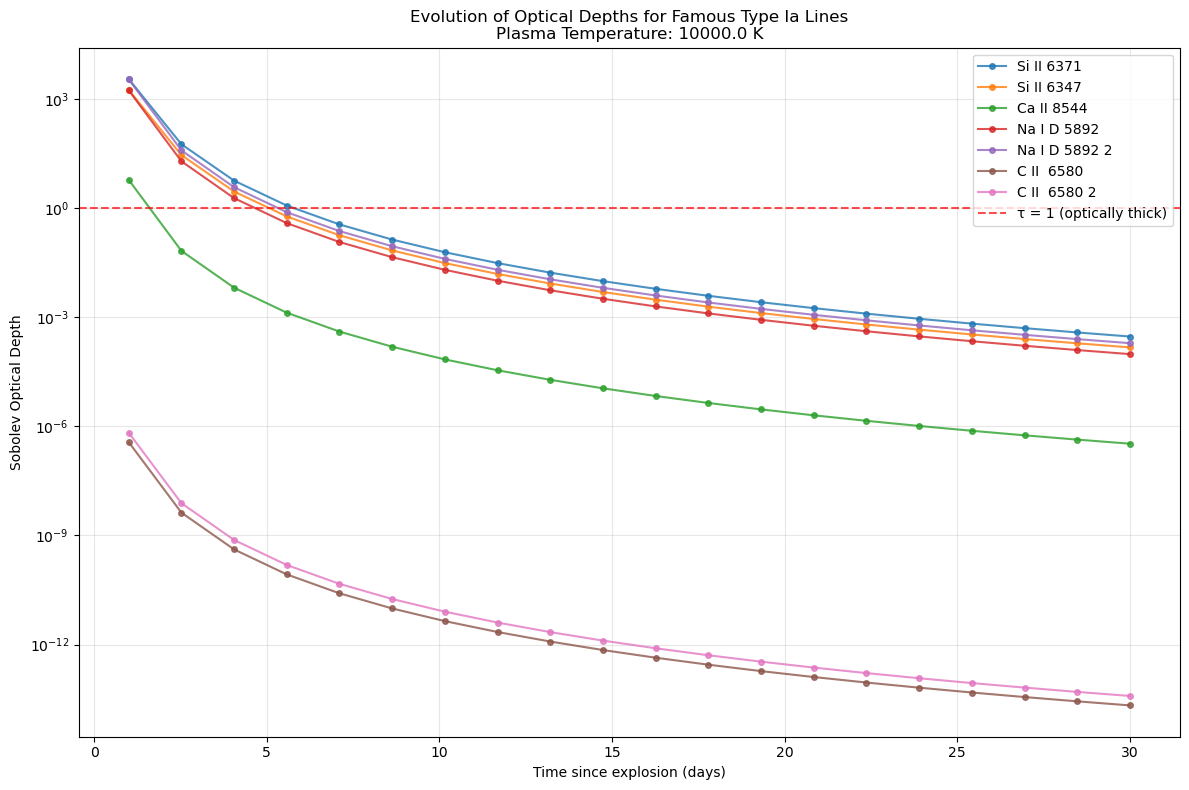

In [20]:
# Example usage with the original parameters
times, tau_results = calculate_optical_depth_evolution()

plot_optical_depth_evolution(times, tau_results=tau_results, plasma_temp=10000*u.K)

**$\blacktriangleright$ TASK: Examine the Time Evolution of Famous SN Ia Lines**

Analyze the optical depth evolution plot you just generated. Notice how different lines show distinct temporal behavior - some start strong and fade quickly, while others may become prominent at later times.

**$\blacktriangleright$ Temperature Sensitivity Investigation:**

Now explore how plasma temperature affects the evolution patterns. Try running the evolution calculation with different temperatures:

- **Cool plasma:** `plasma_temperature=8000*u.K` 
- **Hot plasma:** `plasma_temperature=15000*u.K`

Compare how the **line ratios** change over time in different temperature regimes. For example, examine:
- Si II vs Ca II strength evolution
- Early-time vs late-time dominance patterns
- How quickly lines transition from optically thick (τ > 1) to optically thin (τ < 1)

**Key Questions:**
1. Which lines are most sensitive to temperature changes?
2. Do hotter plasmas show different evolutionary timescales?
3. How do line ratios at early times compare between different temperature scenarios?



# Solution

There's not actually a generic solution to this one. The answers depend highly on what they specifically decide to look at. 

Calculating optical depths (T=15000K):   0%|          | 0/20 [00:00<?, ?it/s]

Converged after 6 iterations with electron density: 15865513513078.703 1 / cm3. Setting the electron density to this number for your plasma.


/var/folders/n4/hw688njd0_1164p8dnqc6v_h0000gn/T/ipykernel_65140/2794084687.py:224: PerformanceWarning: indexing past lexsort depth may impact performance.
  line_data = self.atom_data.lines.loc[(element, ionization_state, lower, upper)]


Converged after 6 iterations with electron density: 1093426914062.492 1 / cm3. Setting the electron density to this number for your plasma.
Converged after 6 iterations with electron density: 280362519557.8391 1 / cm3. Setting the electron density to this number for your plasma.
Converged after 6 iterations with electron density: 111252858110.00522 1 / cm3. Setting the electron density to this number for your plasma.
Converged after 6 iterations with electron density: 55174890690.15768 1 / cm3. Setting the electron density to this number for your plasma.
Converged after 6 iterations with electron density: 31344617788.06375 1 / cm3. Setting the electron density to this number for your plasma.
Converged after 6 iterations with electron density: 19515884328.36542 1 / cm3. Setting the electron density to this number for your plasma.
Converged after 6 iterations with electron density: 12981916123.124783 1 / cm3. Setting the electron density to this number for your plasma.
Converged after 5 

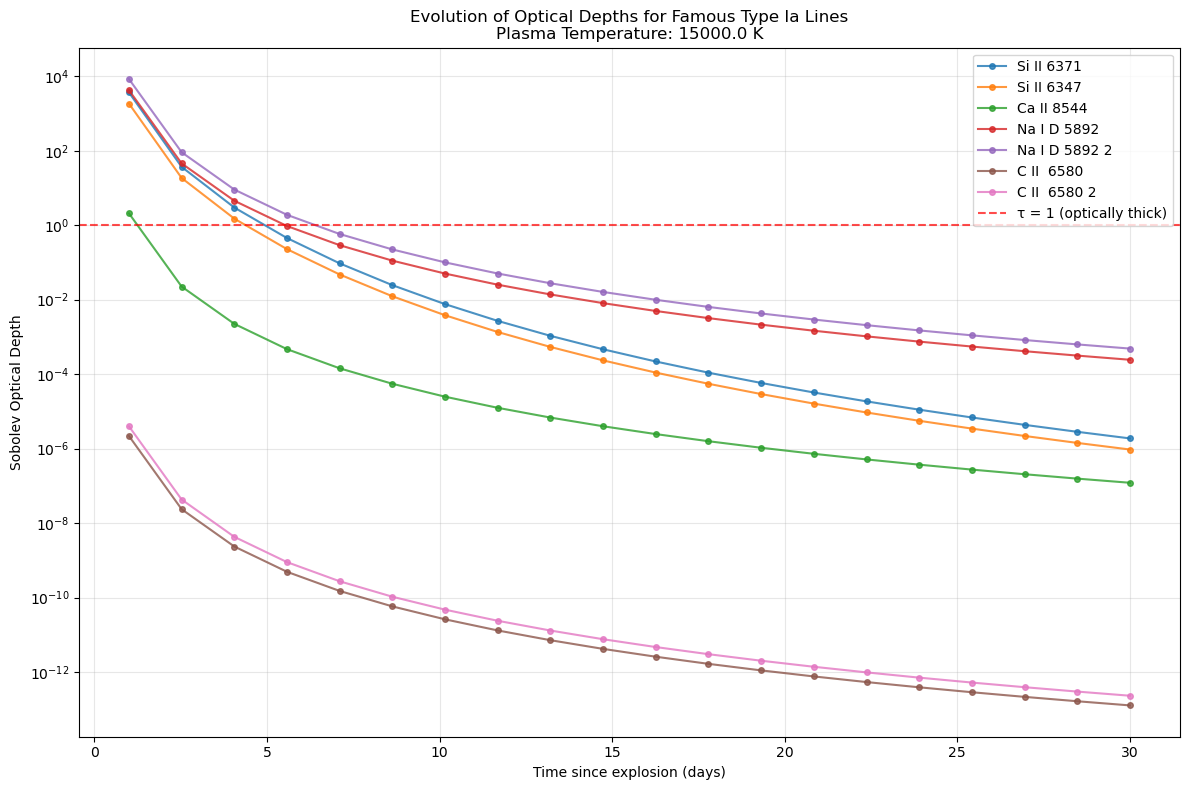

In [21]:
# Example usage with the original parameters, bumping up Carbon by a factor of 100
times, tau_results = calculate_optical_depth_evolution(reference_density_10d=5e8, plasma_temperature=15000*u.K,
                                                       elemental_scaling_dict={6: 10})

plot_optical_depth_evolution(times, tau_results=tau_results, plasma_temp=15000*u.K)

# $\blacktriangleright$ REFLECTION: Physical Realism of Our Model

Take a moment to think critically about the assumptions in our plasma model and whether they represent realistic supernova conditions.

**$\blacktriangleright$ What We Include:**

Our model incorporates **geometric effects** from the expanding supernova:
- Density evolution following ρ(t) ∝ t^-3 due to homologous expansion
- Optical depth calculations using the Sobolev approximation
- Fixed elemental composition throughout the ejecta

**$\blacktriangleright$ What We Ignore:**

However, we make several significant simplifications:

1. **Ejecta Cooling:** We assume constant temperature throughout the evolution. In reality, supernova ejecta cool significantly over time as they expand and the radiation field becomes less dense per unit plasma.

3. **Non-LTE Effects:** Our LTE assumption becomes increasingly poor at lower densities and temperatures.

**$\blacktriangleright$ TASK: Critical Thinking Questions**

1. **Temperature Evolution:** How would cooling plasma (e.g., dropping from 10,000 K to 5,000 K over 30 days) affect the ionization balance and line strengths you calculated?

2. **Radiation Field:** How might changes in the radiation field (harder→softer spectrum) influence which ions dominate at different times?

3. **Model Validity:** At what point in the supernova's evolution do you think our simplified model becomes unrealistic? What observational signatures might reveal these limitations?

4. **Real vs. Calculated:** Given these limitations, how do you interpret the agreement (or disagreement) between your calculations and the observed SN 2002bo spectrum?

**The Big Picture:** This exercise demonstrates both the power and limitations of simplified plasma models in astrophysics. While our basic approach captures key trends, fully realistic supernova spectral modeling requires sophisticated radiative transfer codes that account for all these missing physics!

## Looking Ahead: From Plasma Physics to Radiative Transfer

**$\blacktriangleright$ What You've Accomplished:**

In this exercise, you've built a foundational understanding of:
- How plasma conditions control spectral line formation
- The time evolution of optical depths in expanding supernova ejecta  
- Why Type Ia supernovae show characteristic spectral signatures
- The connection between atomic physics and observable astronomy

**$\blacktriangleright$ The Next Step: TARDIS Integration**

Your plasma calculations provide the foundation for full radiative transfer modeling. In a complete TARDIS simulation, these optical depth calculations would be:

1. **Repeated across the ejecta:** Multiple zones with different compositions and conditions
2. **Coupled to radiative transfer:** Photon packets interact with the plasma you've characterized
3. **Self-consistently solved:** Temperature and ionization respond to the radiation field
4. **Synthesized into spectra:** The final observable that you can compare with telescopes

**Bottom Line:** The plasma physics you've explored here is the essential foundation that makes sophisticated supernova spectral modeling possible!

You could plug this into your radiative transfer simulation on day 1, and you'd have a simple TARDIS!

In [2]:
from IPython import get_ipython
from pathlib import Path
ip = get_ipython()
path = None
if '__vsc_ipynb_file__' in ip.user_ns:
    path = ip.user_ns['__vsc_ipynb_file__']

nb_path = Path(path)
# Get the current notebook name
current_notebook = nb_path.name

# Create the student version by replacing 'instructor' with 'student'
output_notebook = current_notebook.replace('instructor', 'student')

# Run the nbconvert command
!jupyter nbconvert {current_notebook} --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_cell_tags="['solution']" --to notebook --output {output_notebook}

print(f"Converted {current_notebook} to {output_notebook}")


[NbConvertApp] Converting notebook 2_plasma_exploration_instructor.ipynb to notebook
[NbConvertApp] Writing 1224496 bytes to 2_plasma_exploration_student.ipynb
Converted 2_plasma_exploration_instructor.ipynb to 2_plasma_exploration_student.ipynb
